In [2]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.interpolate import CubicSpline
from datetime import datetime, timedelta

sys.path.append('../..')

from data.dataloader import Covid19IndiaLoader
from data.processing import get_dataframes_cached, get_data

from utils.util import rollingavg, train_test_split
from utils.enums.columns import Columns

## Data

In [2]:
district = 'Pune'
state = 'Maharashtra'
disable_tracker = True

loader = Covid19IndiaLoader()
dataframes = loader.get_covid19india_api_data()

data = get_data(dataframes, state, district, disable_tracker=disable_tracker)
data['date'] = pd.to_datetime(data['date'])
data = data.rename(columns={"total": "total_infected", "active": "hospitalised"})

fetching from athenadb...


In [3]:
cols = [c.name for c in Columns.which_compartments()]
actual_start_date = data['date'].min()+timedelta(5)
smooth_data = data.copy(deep=True)
for col in cols:
    smooth_data[col] = rollingavg(data[col], 5)
smooth_data = smooth_data.dropna(subset=cols, how='any')
_, smooth_data = train_test_split(smooth_data, actual_start_date-timedelta(1))
smooth_data.head()

,state,district,date,total_infected,hospitalised,recovered,deceased
5,maharashtra,pune,2020-04-24,967.4,760.2,144.4,62.8
6,maharashtra,pune,2020-04-25,1056.4,834.4,155.2,66.8
7,maharashtra,pune,2020-04-26,1149.0,908.4,169.8,70.8
8,maharashtra,pune,2020-04-27,1239.4,978.2,186.6,74.6
9,maharashtra,pune,2020-04-28,1329.0,1041.0,209.6,78.4


## IHME s2 performance, SEIR s3 performance

In [4]:
res = pd.read_csv('../../outputs/consolidated/Pune_IHME_performance.csv')
val_res = res[res['type'] == 'val'].reset_index(drop=True)
train_res = res[res['type'] == 'train'].reset_index(drop=True)
val_res

,start_date,shift,type,hospitalised,deceased,recovered,total_infected
0,4-24-20,0,val,2.182527,3.749682,2.502073,3.772327
1,4-24-20,5,val,8.581472,2.558110,23.834932,2.925015
2,4-24-20,10,val,8.311716,1.116586,9.176791,2.512689
3,4-24-20,15,val,12.717218,2.887176,13.570228,1.144213
4,4-24-20,20,val,5.056130,1.274849,1.297185,3.412654
5,4-24-20,25,val,11.234138,1.680721,0.864071,3.021768
6,4-24-20,30,val,1.649247,1.214861,2.461061,5.899570
7,4-24-20,35,val,2.476049,1.648996,1.140694,0.771559


In [5]:
res = pd.read_csv('../../outputs/consolidated/Pune_SEIR_s3_performance.csv')
seir_val_res = res[res["type"] == "val"].reset_index(drop=True)
exp1, exp2, exp3 = seir_val_res.iloc[0::3, :], seir_val_res.iloc[1::3, :], seir_val_res.iloc[2::3, :]

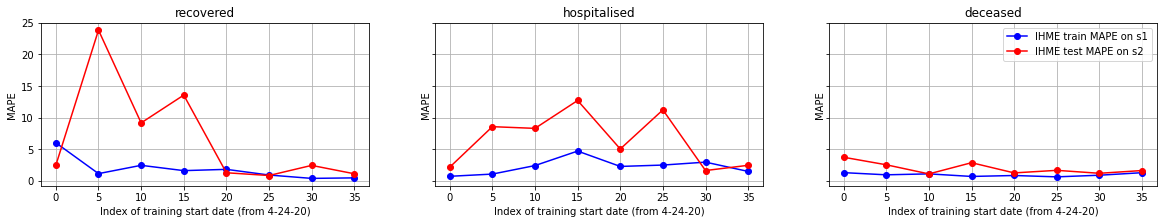

In [6]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,3))
plt.title('Pune MAPE on s2')
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(train_res['shift'], train_res[col], 'o-', label='IHME train MAPE on s1', color='blue')
    ax[i].plot(val_res['shift'], val_res[col], 'o-', label='IHME test MAPE on s2', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

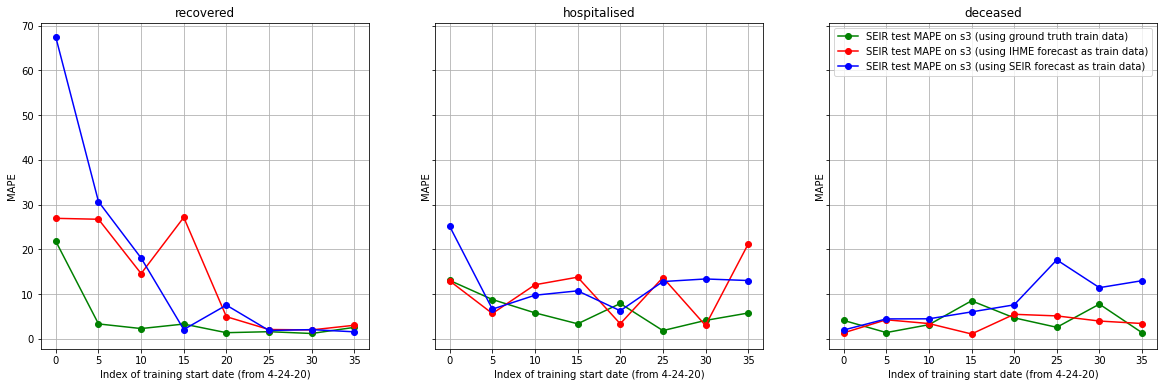

In [7]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp1['shift'], exp1[col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data)', color='green')
    ax[i].plot(exp2['shift'], exp2[col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].plot(exp3['shift'], exp3[col], 'o-', label='SEIR test MAPE on s3 (using SEIR forecast as train data)', color='blue')
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
    ax[i].title.set_text(col)
plt.legend()

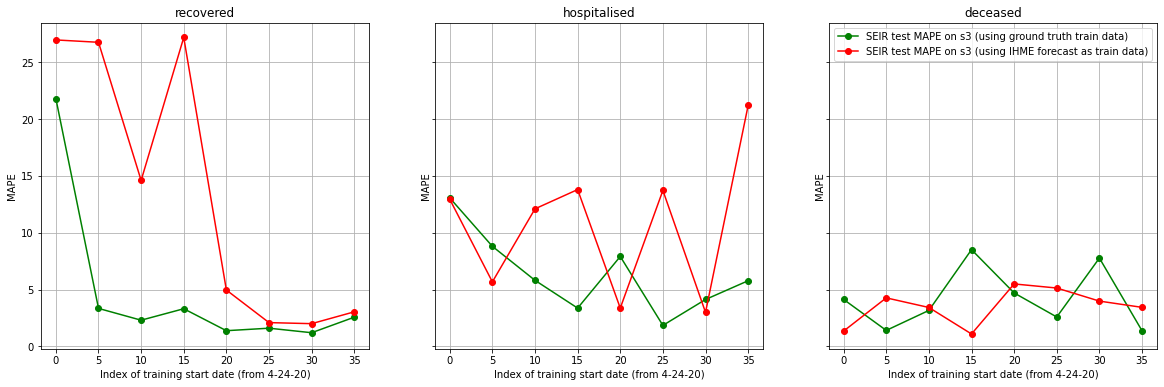

In [8]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp1['shift'], exp1[col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data)', color='green')
    ax[i].plot(exp2['shift'], exp2[col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

## Variance/smoothness analysis

In [9]:
def get_var_series(compartment, data, train_period, smoothness):
    variances = []
    mean_smooth = []
    dates = []
    start = data['date'].min()
    i = 0
    while start+timedelta(train_period) < data['date'].max():
        dates.append(start)
        variances.append(np.var(data[compartment].iloc[i:i+train_period]))
        mean_smooth.append(np.mean(smoothness[i:i+train_period]))
        i += 1
        start += timedelta(1)
    return variances, mean_smooth, dates

def get_smoothness(compartment, data):
    cs = CubicSpline(data['date'], data[compartment])
#     plt.plot(data['date'].values, cs(data['date']), '--', 'brown')
    second_deriv = cs.__call__(data['date'], nu=2)
    smoothness = [x**2 for x in second_deriv] 
    return smoothness

def plot_analysis(compartment, losses, variances, smoothness, dates):
    shifts = [(dates[i]-min(dates)).days for i in range(len(dates))]
    plt.figure(figsize=(12,12))
    plt.plot(losses['shift'], losses[compartment], 'o-', label='mape', color='red')
    plt.plot(shifts, variances, color='black', label='variance')
    plt.plot(shifts, smoothness, '--', color='blue', label='smoothness')
    plt.legend()
    plt.grid()
    plt.title(compartment)

In [10]:
var_scale_factors = [10000, 200, 4000, 100000]  # train period 10
smooth_scale_factors = [2.5e54, 2e55, 5e53, 1e53]

for i, col in enumerate(cols):
    smoothness = get_smoothness(col, smooth_data)
    variances, mean_smoothness, dates = get_var_series(col, smooth_data, 10, smoothness)
    scaled_variances = [x/var_scale_factors[i] for x in variances]
    scaled_smoothness = [x*smooth_scale_factors[i] for x in mean_smoothness]
    plot_analysis(col, val_res, scaled_variances[:35], scaled_smoothness[:35], dates[:35])

Graphs


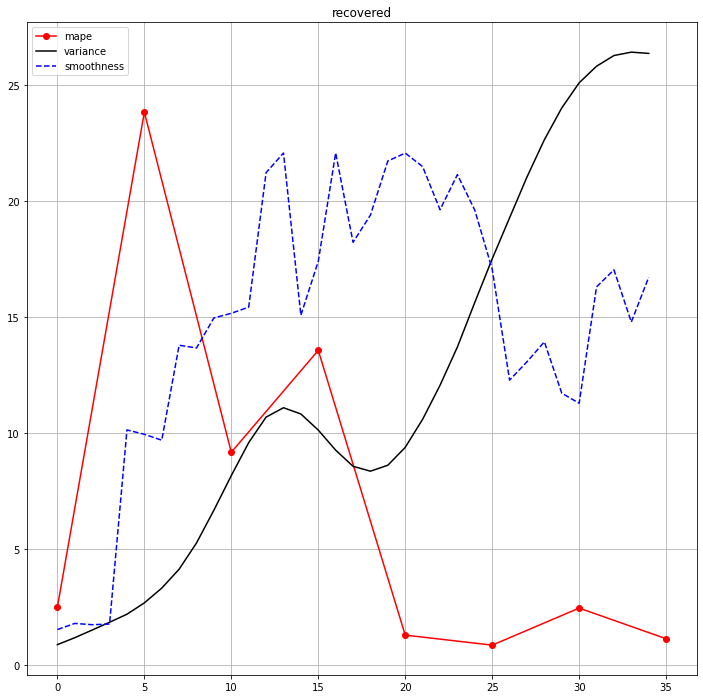

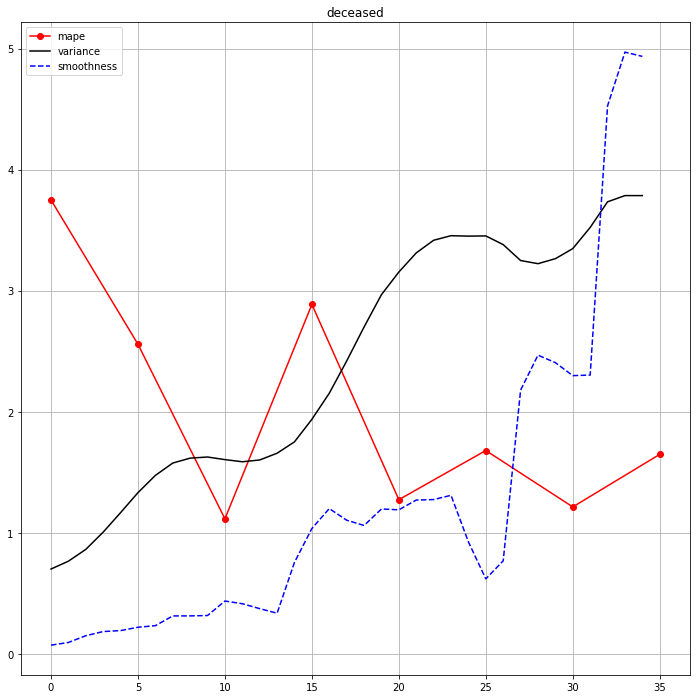

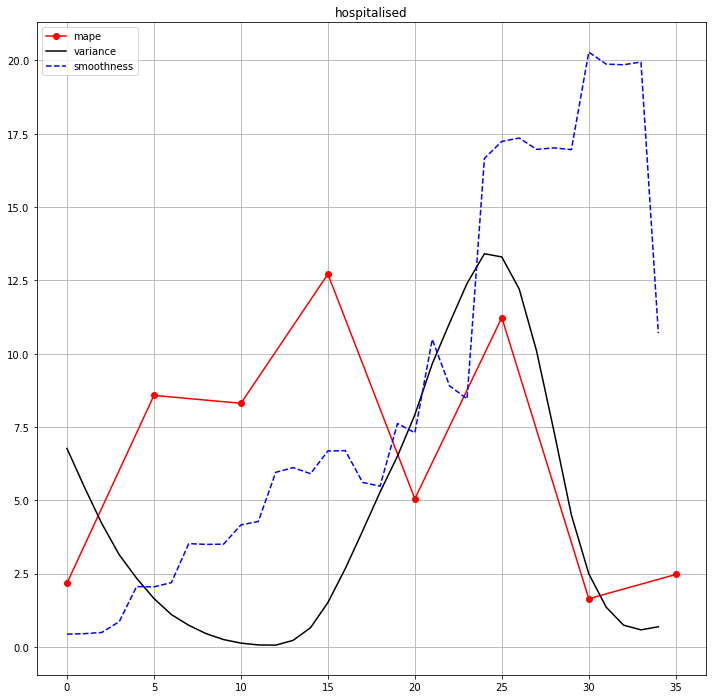

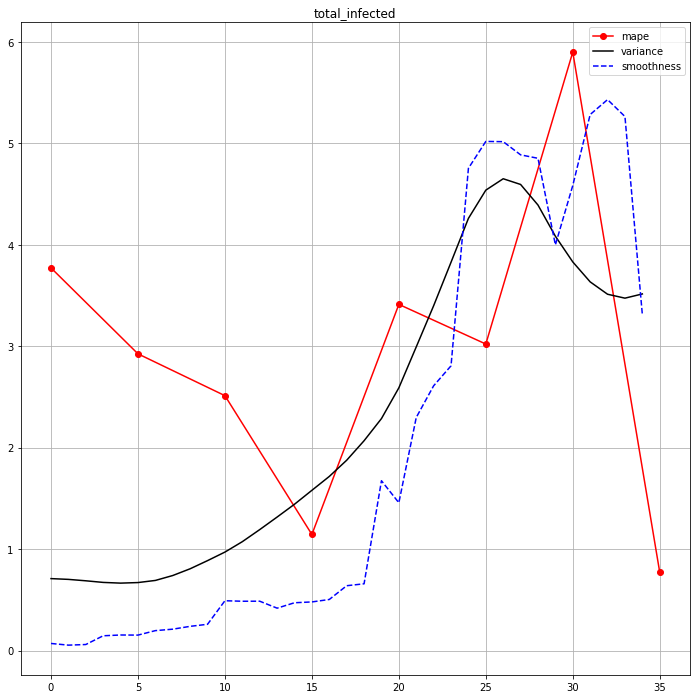

In [11]:
print("Graphs")

## IHME s2 performance, SEIR s3 performance (with uncertainty)

In [12]:
res = pd.read_csv('../../outputs/consolidated/Pune_IHME_performance_July_1.csv')
val_res = res[res['type'] == 'val'].reset_index(drop=True)
train_res = res[res['type'] == 'train'].reset_index(drop=True)
uncertainty_res = res[res['type'] == 'average s2 uncertainty'].reset_index(drop=True)

In [13]:
res = pd.read_csv('../../outputs/consolidated/Pune_SEIR_s3_performance_July_1.csv')
seir_val_res = res[res["type"] == "val"].reset_index(drop=True)
exp1, exp2, exp3 = seir_val_res.iloc[0::3, :], seir_val_res.iloc[1::3, :], seir_val_res.iloc[2::3, :]

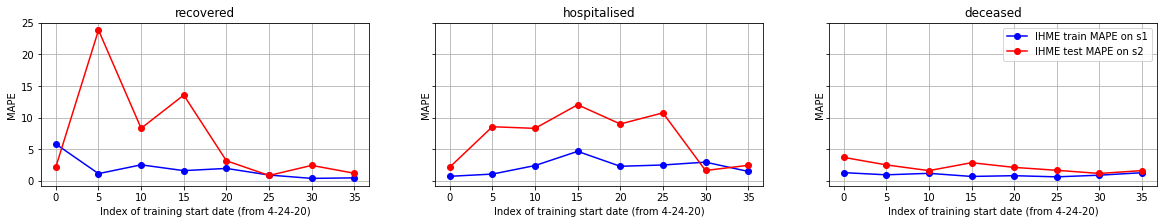

In [14]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,3))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(train_res['shift'], train_res[col], 'o-', label='IHME train MAPE on s1', color='blue')
    ax[i].plot(val_res['shift'], val_res[col], 'o-', label='IHME test MAPE on s2', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

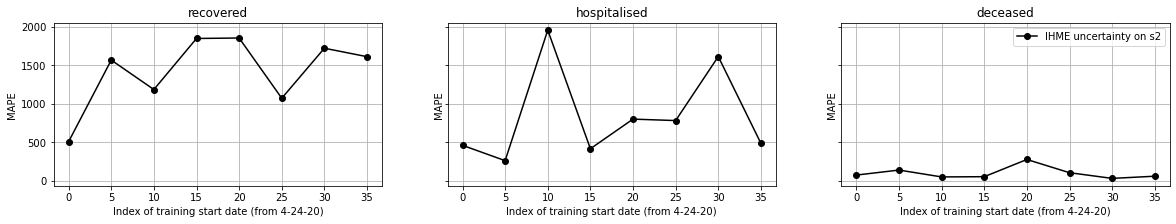

In [15]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,3))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(uncertainty_res['shift'], uncertainty_res[col], 'o-', label='IHME uncertainty on s2', color='black')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

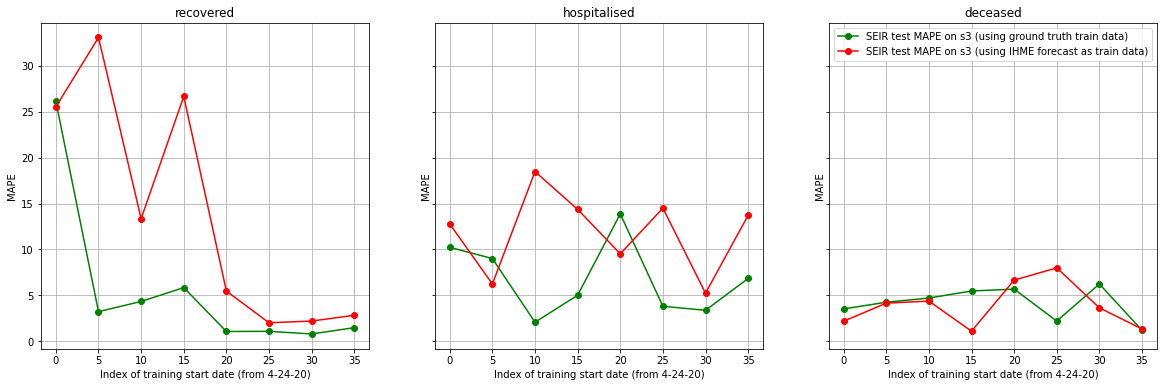

In [16]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp1['shift'], exp1[col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data)', color='green')
    ax[i].plot(exp2['shift'], exp2[col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

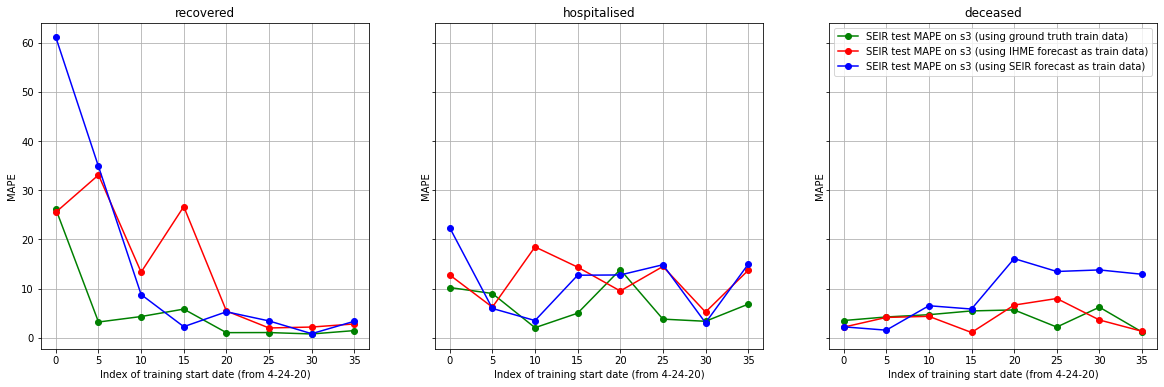

In [17]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp1['shift'], exp1[col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data)', color='green')
    ax[i].plot(exp2['shift'], exp2[col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].plot(exp3['shift'], exp3[col], 'o-', label='SEIR test MAPE on s3 (using SEIR forecast as train data)', color='blue')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

## Ahmedabad

In [18]:
res = pd.read_csv('../../outputs/consolidated/Ahmedabad_IHME_performance_July_1.csv')
val_res = res[res['type'] == 'val'].reset_index(drop=True)
train_res = res[res['type'] == 'train'].reset_index(drop=True)
uncertainty_res = res[res['type'] == 'average s2 uncertainty'].reset_index(drop=True)

In [19]:
res = pd.read_csv('../../outputs/consolidated/Ahmedabad_SEIR_s3_performance_July_1.csv')
seir_val_res = res[res["type"] == "val"].reset_index(drop=True)
exp1, exp2, exp3 = seir_val_res.iloc[0::3, :], seir_val_res.iloc[1::3, :], seir_val_res.iloc[2::3, :]

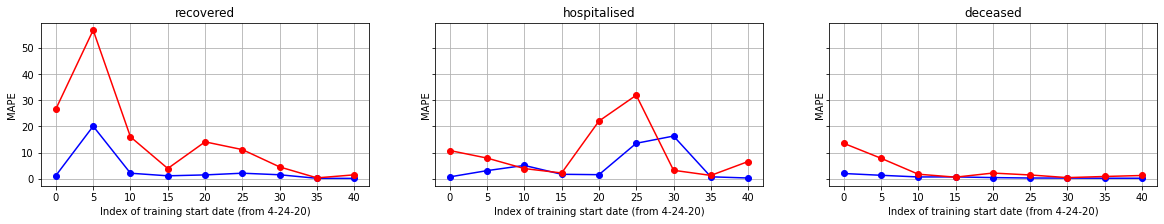

In [20]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,3))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(train_res['shift'], train_res[col], 'o-', label='data', color='blue')
    ax[i].plot(val_res['shift'], val_res[col], 'o-', label='data', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()

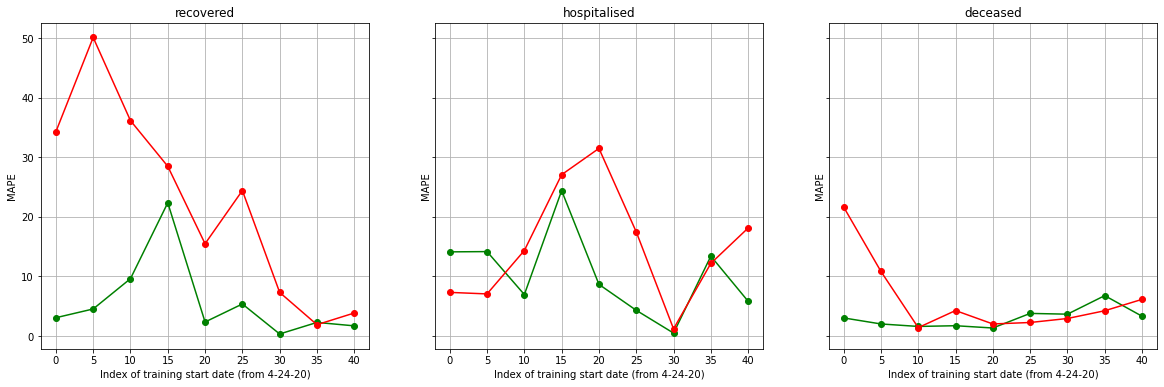

In [21]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp1['shift'], exp1[col], 'o-', label='data', color='green')
    ax[i].plot(exp2['shift'], exp2[col], 'o-', label='data', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()

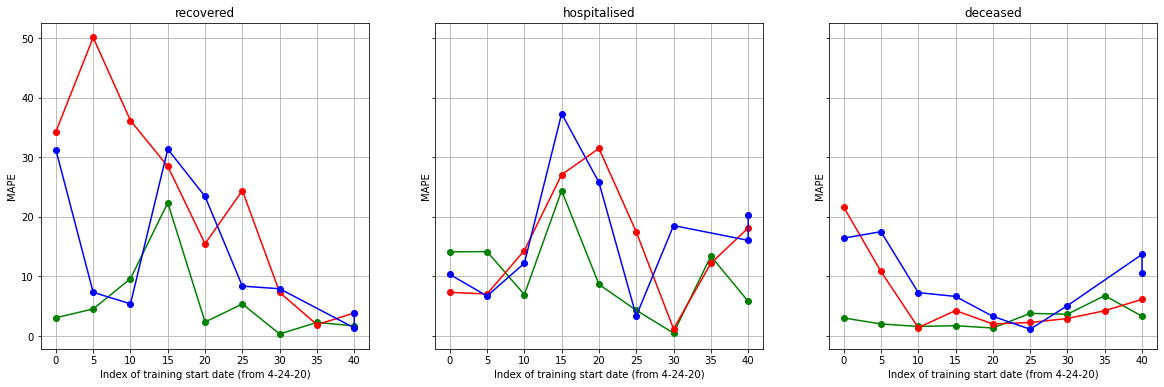

In [22]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp1['shift'], exp1[col], 'o-', label='data', color='green')
    ax[i].plot(exp2['shift'], exp2[col], 'o-', label='data', color='red')
    ax[i].plot(exp3['shift'], exp3[col], 'o-', label='data', color='blue')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()

## IHME s2 performance, SEIR s3 and baseline performance

In [23]:
res = pd.read_csv('../../outputs/consolidated/Pune_IHME_performance_July_5.csv') # c2_train_period = 5
val_res = res[res['type'] == 'val'].reset_index(drop=True)
train_res = res[res['type'] == 'train'].reset_index(drop=True)
uncertainty_res = res[res['type'] == 'average s2 uncertainty'].reset_index(drop=True)

In [24]:
res = pd.read_csv('../../outputs/consolidated/Pune_SEIR_s3_performance_July_5.csv')
seir_val_res = res[res["type"] == "val"].reset_index(drop=True)
seir_val_res

,shift,type,hospitalised,total_infected,deceased,recovered,exp
0,0,val,12.929951,0.739573,4.909448,20.615433,1
1,0,val,9.781057,2.840831,3.318557,20.151300,2
2,0,val,22.330913,2.311251,3.761709,57.103661,3
3,0,val,20.020423,2.098350,2.230085,45.548400,4
4,5,val,15.382856,4.216471,2.416215,3.488139,1
5,5,val,8.406957,10.851819,2.303420,22.355797,2
6,5,val,12.053816,10.323210,1.630985,17.240279,3
7,5,val,6.335561,11.105065,6.708807,35.761826,4
8,10,val,4.288623,3.081284,1.947211,3.293105,1
9,10,val,7.311963,7.638327,2.255737,17.422357,2


In [25]:
exp = dict()
for i in range(4):
    exp[i] = seir_val_res[seir_val_res["exp"] == i+1].reset_index(drop=True)

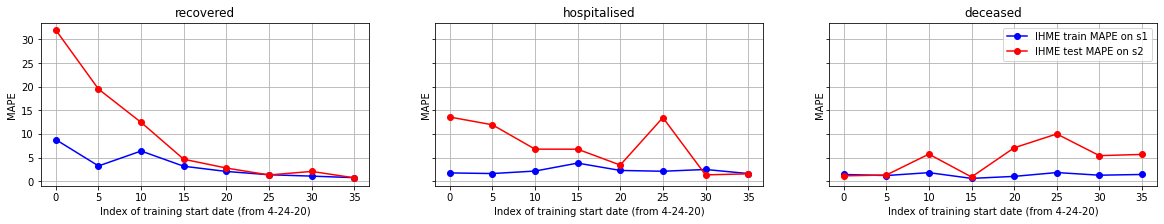

In [26]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,3))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(train_res['shift'], train_res[col], 'o-', label='IHME train MAPE on s1', color='blue')
    ax[i].plot(val_res['shift'], val_res[col], 'o-', label='IHME test MAPE on s2', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

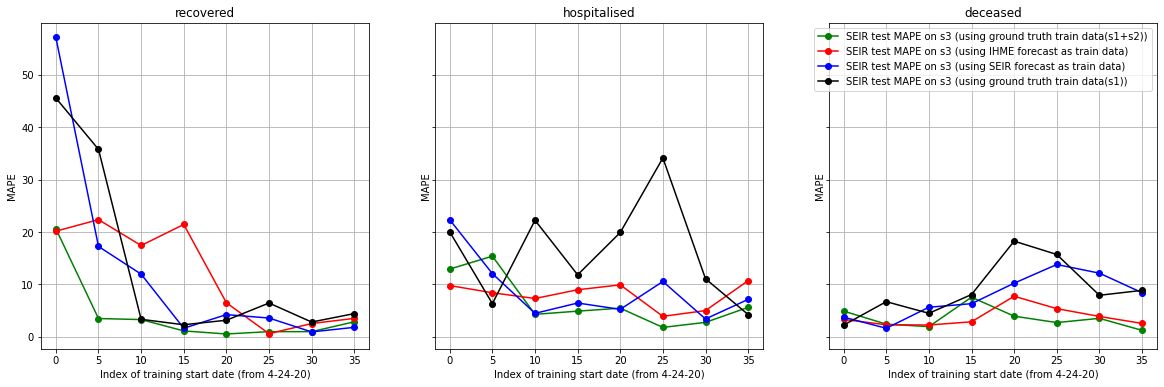

In [27]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp[0]['shift'], exp[0][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data(s1+s2))', color='green')
    ax[i].plot(exp[1]['shift'], exp[1][col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].plot(exp[2]['shift'], exp[2][col], 'o-', label='SEIR test MAPE on s3 (using SEIR forecast as train data)', color='blue')
    ax[i].plot(exp[3]['shift'], exp[3][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data(s1))', color='black')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

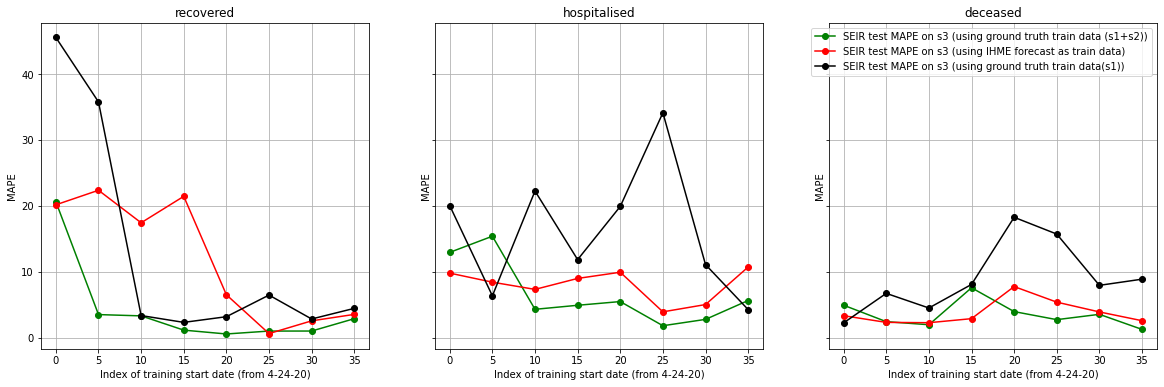

In [28]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp[0]['shift'], exp[0][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data (s2))', color='green')
    ax[i].plot(exp[1]['shift'], exp[1][col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].plot(exp[3]['shift'], exp[3][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data(s1))', color='black')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

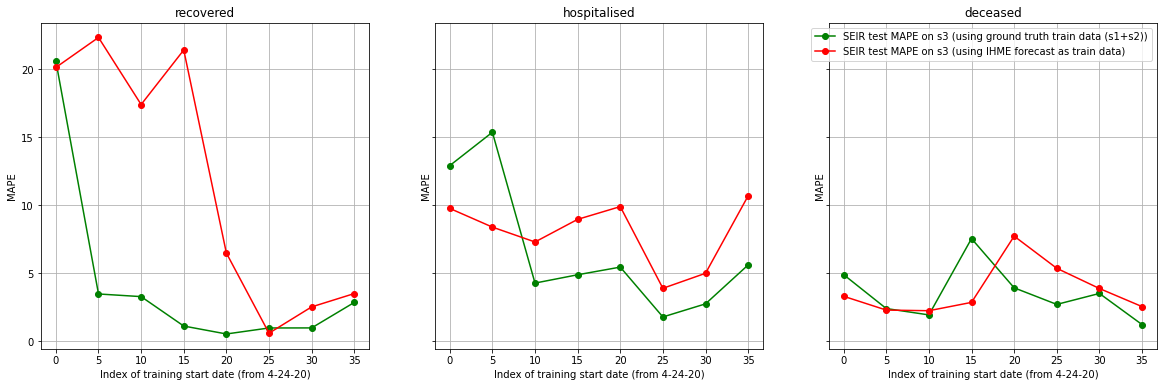

In [29]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp[0]['shift'], exp[0][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data (s2))', color='green')
    ax[i].plot(exp[1]['shift'], exp[1][col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

## IHME s2 performance, SEIR s3 and baseline performance

In [4]:
res = pd.read_csv('../../outputs/consolidated/Pune_SEIR_s3_performance_July_6.csv') # c2_train_period = 7
seir_val_res = res[res["type"] == "val"].reset_index(drop=True)
seir_val_res

,shift,type,hospitalised,total_infected,deceased,recovered,exp
0,0,val,6.476144,7.669804,3.886116,28.423688,1
1,0,val,11.680466,3.820363,1.961241,27.958791,2
2,0,val,22.461523,3.850061,2.153686,66.387552,3
3,0,val,18.263544,3.449023,3.688105,45.021232,4
4,5,val,17.602361,7.608506,1.040361,2.567419,1
5,5,val,9.992066,18.141012,2.799356,33.790740,2
6,5,val,6.625854,15.978561,2.303420,42.805564,3
7,5,val,5.688927,12.013101,5.349922,34.392804,4
8,10,val,3.569549,4.491599,2.630941,5.520812,1
9,10,val,15.251596,6.914932,4.025572,19.339265,2


In [5]:
exp = dict()
for i in range(4):
    exp[i] = seir_val_res[seir_val_res["exp"] == i+1].reset_index(drop=True)

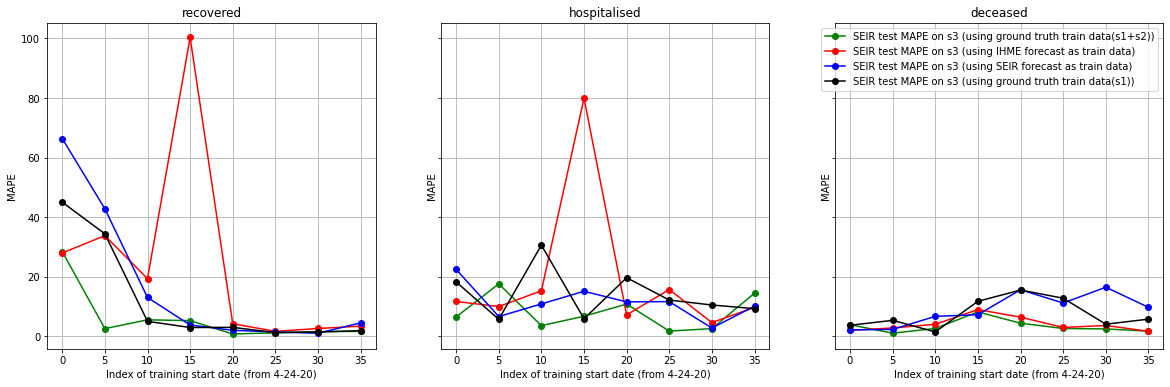

In [6]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp[0]['shift'], exp[0][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data(s1+s2))', color='green')
    ax[i].plot(exp[1]['shift'], exp[1][col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].plot(exp[2]['shift'], exp[2][col], 'o-', label='SEIR test MAPE on s3 (using SEIR forecast as train data)', color='blue')
    ax[i].plot(exp[3]['shift'], exp[3][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data(s1))', color='black')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

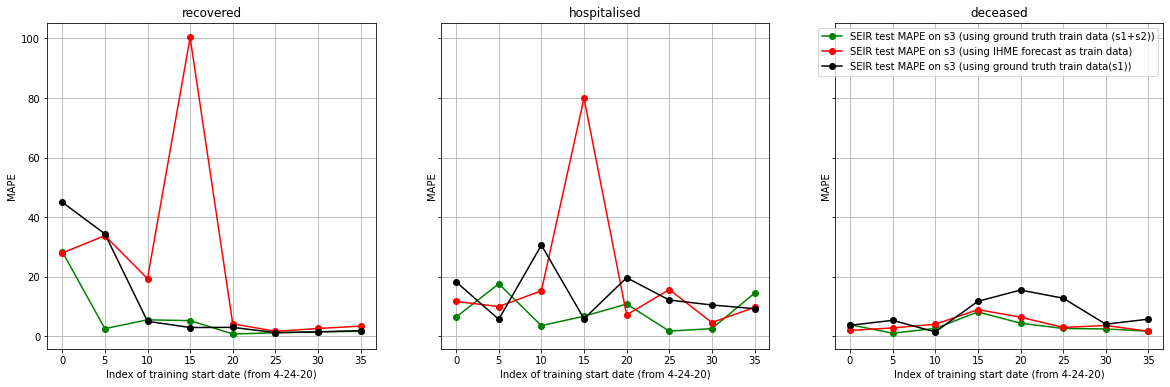

In [11]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp[0]['shift'], exp[0][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data (s1+s2))', color='green')
    ax[i].plot(exp[1]['shift'], exp[1][col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].plot(exp[3]['shift'], exp[3][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data(s1))', color='black')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
plt.legend()

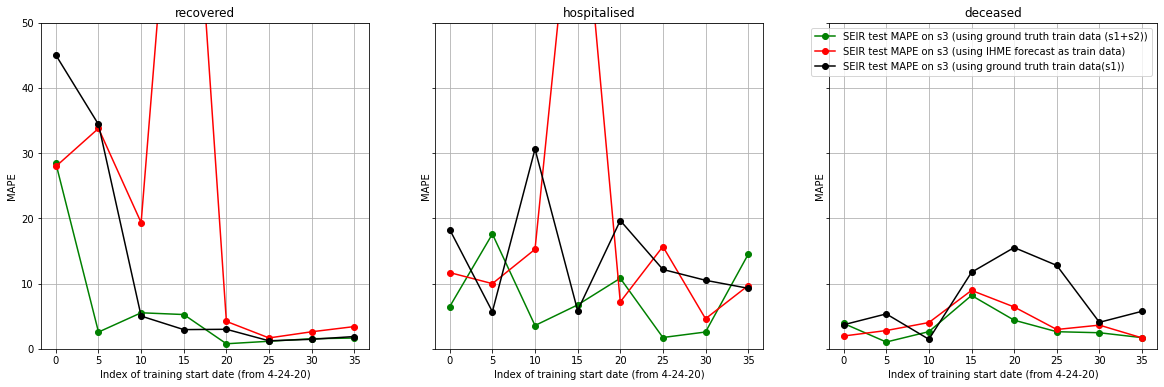

In [14]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
cols_plot = ['recovered', 'hospitalised', 'deceased']
for i, col in enumerate(cols_plot):
    ax[i].plot(exp[0]['shift'], exp[0][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data (s1+s2))', color='green')
    ax[i].plot(exp[1]['shift'], exp[1][col], 'o-', label='SEIR test MAPE on s3 (using IHME forecast as train data)', color='red')
    ax[i].plot(exp[3]['shift'], exp[3][col], 'o-', label='SEIR test MAPE on s3 (using ground truth train data(s1))', color='black')
    ax[i].title.set_text(col)
    ax[i].set_xlabel('Index of training start date (from 4-24-20)', fontsize=10)
    ax[i].set_ylabel('MAPE', fontsize=10)
    ax[i].grid()
    ax[i].set_ylim(0,50)
plt.legend()